In [82]:
# core
# This script is adapted from a public GitHub repository.
# Original source: https://github.com/deep-finder/cryoet-deepfinder/tree/master
# Author: Inria,  Emmanuel Moebel, Charles Kervrann
# License: GPL v3.0

# from deepfindET.utils import copick_tools as copicktools
# from deepfindET.utils import common as cm
import copick, h5py, os, sys
from itertools import chain
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

matplotlib.use("agg")  # necessary else: AttributeError: 'NoneType' object has no attribute 'is_interactive'

class DeepFindET:
    def __init__(self):
        self.obs_list = [observer_print]

    # Useful for sending prints to GUI
    def set_observer(self, obs):
        self.obs_list.append(obs)

    # "Master print" calls all observers for prints
    def display(self, message):
        for obs in self.obs_list:
            obs.display(message)

    # For checking inputs:
    def is_3D_nparray(self, v, varname):
        if type(v) != np.ndarray:
            self.display(
                'DeepFindET message: variable "' + varname + '" is ' + str(type(v)) + ". Expected is numpy array.",
            )
            sys.exit()
        if len(v.shape) != 3:
            self.display(
                'DeepFindET message: variable "'
                + varname
                + '" is a '
                + str(len(v.shape))
                + "D array. Expected is a 3D array.",
            )
            sys.exit()

    def is_int(self, v, varname):
        if type(v) != int and type(v) != np.int8 and type(v) != np.int16:
            self.display('DeepFindET message: variable "' + varname + '" is ' + str(type(v)) + ". Expected is int.")
            sys.exit()

    def is_positive_int(self, v, varname):
        self.is_int(v, varname)
        if v <= 0:
            self.display('DeepFindET message: variable "' + varname + '" is <=0. Expected is >0.')
            sys.exit()

    def is_multiple_4_int(self, v, varname):
        self.is_int(v, varname)
        if v % 4 != 0:
            self.display('DeepFindET message: variable "' + varname + '" should be a multiple of 4.')
            sys.exit()

    def is_str(self, v, varname):
        if type(v) != str:
            self.display('DeepFindET message: variable "' + varname + '" is ' + str(type(v)) + ". Expected is str.")
            sys.exit()

    def is_h5_path(self, v, varname):
        self.is_str(v, varname)
        s = os.path.splitext(v)
        if s[1] != ".h5":
            self.display('DeepFindET message: "' + str(varname) + '" points to ' + s[1] + ", expected is .h5")
            sys.exit()

    def is_list(self, v, varname):
        if type(v) != list:
            self.display('DeepFindET message: variable "' + varname + '" is ' + str(type(v)) + ". Expected is list.")
            sys.exit()

    def check_array_minsize(self, v, varname):
        lmin = v[1]  # is expected to be int (e.g. patch length)
        if v[0].shape[0] < lmin and v[0].shape[1] < lmin and v[0].shape[2] < lmin:
            self.display(
                'DeepFindET message: the array "'
                + varname[0]
                + '" has shape '
                + str(v[0].shape)
                + '. Needs to be larger than array "'
                + varname[1]
                + '", which has shape ('
                + str(v[1])
                + ","
                + str(v[1])
                + ","
                + str(v[1])
                + ").",
            )
            sys.exit()

# Following observer classes are needed to send prints to GUI:
class observer_print:
    def display(message):
        print(message)

# Retrieves variable name as a str:
# Found here: https://stackoverflow.com/questions/18425225/getting-the-name-of-a-variable-as-a-string
def retrieve_var_name(x, Vars=vars()):
    for k in Vars:
        if type(x) == type(Vars[k]) and x is Vars[k]:
            return k
    return None

# This functions loads the training set at specified paths.
# INPUTS:
#   path_data  : list of strings '/path/to/tomogram.ext'
#   path_target: list of strings '/path/to/target.ext'
#                The idx of above lists correspond to each other so that (path_data[idx], path_target[idx]) corresponds
#                to a (tomog, target) pair
#   dset_name  : can be usefull if files are stored as .h5
# OUTPUTS:
#   data_list  : list of 3D numpy arrays (tomograms)
#   target_list: list of 3D numpy arrays (annotated tomograms)
#                In the same way as for the inputs, (data_list[idx],target_list[idx]) corresponds to a (tomo,target) pair
def load_copick_datasets(copickPath, train_instance, tomoIDs=None):
    data_list = {}
    target_list = {}

    copickRoot = copick.from_file(copickPath)
    if tomoIDs is None:
        tomoIDs = [run.name for run in copickRoot.runs]

    print(f"Loading Targets and Tomograms for the Following Runs: {list(tomoIDs)}")
    for idx in tqdm(range(len(tomoIDs))):
        target_list[tomoIDs[idx]] = copicktools.get_copick_segmentation(
            copickRoot.get_run(tomoIDs[idx]),
            train_instance.labelName,
            train_instance.labelUserID,
            train_instance.sessionID,
        )[:]
        data_list[tomoIDs[idx]] = copicktools.read_copick_tomogram_group(
            copickRoot,
            train_instance.voxelSize,
            train_instance.tomoAlg,
            tomoIDs[idx],
        )[0][:]

        if data_list[tomoIDs[idx]].shape != target_list[tomoIDs[idx]].shape:
            print(f"DeepFinder Message: tomogram and target for run {tomoIDs[idx]} are not of same size!")
            sys.exit()

    return data_list, target_list


# This function applies bootstrap (i.e. re-sampling) in case of unbalanced classes.
# Given an objlist containing objects from various classes, this function outputs an equal amount of objects for each
# class, each objects being uniformely sampled inside its class set.
# INPUTS:
#   objlist: list of dictionaries
#   Nbs    : number of objects to sample from each class
# OUTPUT:
#   bs_idx : list of indexes corresponding to the bootstraped objects
def get_bootstrap_idx(objlist, Nbs):
    # Get a list containing the object class labels (from objlist):
    Nobj = len(objlist)
    label_list = []
    for idx in range(0, Nobj):
        label_list.append(objlist[idx]["label"])

    lblTAB = np.unique(label_list)  # vector containing unique class labels

    # Bootstrap data so that we have equal frequencies (1/Nbs) for all classes:
    # ->from label_list, sample Nbs objects from each class
    bs_idx = []
    for l in lblTAB:
        bs_idx.append(np.random.choice(np.array(np.nonzero(np.array(label_list) == l))[0], Nbs))

    bs_idx = np.concatenate(bs_idx)
    return bs_idx


def query_available_picks(copickRoot, tomoIDs=None, targets=None):
    # Load TomoIDs - Default is Read All TomoIDs from Path
    if tomoIDs is None:
        tomoIDs = [run.name for run in copickRoot.runs]

    labelList = []
    tomoIDList = []
    pickIndList = []
    proteinIndList = []
    proteinCoordsList = []

    for tomoInd in range(len(tomoIDs)):
        copickRun = copickRoot.get_run(tomoIDs[tomoInd])

        if targets is None:
            query = copickRun.picks
        else:
            query = []
            for target_name in targets:
                query += copickRun.get_picks(
                    object_name=target_name,
                    user_id=targets[target_name]["user_id"],
                    session_id=targets[target_name]["session_id"],
                )

        for proteinInd in range(len(query)):
            picks = query[proteinInd]

            nPicks = len(picks.points)
            tomoIDList.append([tomoIDs[tomoInd]] * nPicks)
            pickIndList.append(list(range(nPicks)))
            proteinIndList.append([proteinInd] * nPicks)

            proteinCoordsList.append(picks.points)
            labelList.append([copicktools.get_pickable_object_label(copickRoot, picks.pickable_object_name)] * nPicks)

    labelList = np.array(list(chain.from_iterable(labelList)))
    tomoIDList = np.array(list(chain.from_iterable(tomoIDList)))
    pickIndList = np.array(list(chain.from_iterable(pickIndList)))
    proteinIndList = np.array(list(chain.from_iterable(proteinIndList)))
    proteinCoordsList = np.array(list(chain.from_iterable(proteinCoordsList)))

    return {
        "labelList": labelList,
        "tomoIDlist": tomoIDList,
        "pickIndList": pickIndList,
        "proteinIndList": proteinIndList,
        "proteinCoordsList": proteinCoordsList,
    }


def get_copick_boostrap_idx(organizedPicksDict, Nbs):
    # Bootstrap data so that we have equal frequencies (1/Nbs) for all classes:
    # ->from label_list, sample Nbs objects from each class
    bs_idx = []
    tomoID_idx = []
    pick_idx = []
    protein_idx = []
    protein_picks = []
    lblTAB = np.unique(organizedPicksDict["labelList"])  # vector containing unique class labels
    for l in lblTAB:
        bsIndex = np.random.choice(np.array(np.nonzero(organizedPicksDict["labelList"] == l))[0], Nbs)

        bs_idx.append(bsIndex)
        pick_idx.append(organizedPicksDict["pickIndList"][bsIndex])
        tomoID_idx.append(organizedPicksDict["tomoIDlist"][bsIndex])
        protein_idx.append(organizedPicksDict["proteinIndList"][bsIndex])
        protein_picks.append(organizedPicksDict["proteinCoordsList"][bsIndex])

    return {
        "bs_idx": np.concatenate(bs_idx),
        "tomoID_idx": np.concatenate(tomoID_idx),
        "protein_idx": np.concatenate(protein_idx),
        "pick_idx": np.concatenate(pick_idx),
        "protein_coords": np.concatenate(protein_picks),
    }


# Takes position specified in 'obj', applies random shift to it, and then checks if the patch around this position is
# out of the tomogram boundaries. If so, the position is shifted to that patch is inside the tomo boundaries.
# INPUTS:
#   tomodim: tuple (dimX,dimY,dimZ) containing size of tomogram
#   p_in   : int lenght of patch in voxels
#   obj    : dictionary obtained when calling objlist[idx]
#   Lrnd   : int random shift in voxels applied to position
# OUTPUTS:
#   x,y,z  : int,int,int coordinates for sampling patch safely
def get_copick_patch_position(tomodim, p_in, Lrnd, voxelSize, copicks):
    # sample at coordinates specified in obj=objlist[idx]
    x = int(copicks.location.x / voxelSize)
    y = int(copicks.location.y / voxelSize)
    z = int(copicks.location.z / voxelSize)

    x,y,z = add_random_shift(tomodim,p_in,Lrnd,x,y,z)

    return x, y, z

def add_random_shift(tomodim, p_in, Lrnd, x,y,z):

    # Add random shift to coordinates:
    x = x + np.random.choice(range(-Lrnd,Lrnd+1))
    y = y + np.random.choice(range(-Lrnd,Lrnd+1))
    z = z + np.random.choice(range(-Lrnd,Lrnd+1))
    
    # Shift position if too close to border:
    if (x<p_in) : x = p_in
    if (y<p_in) : y = p_in
    if (z<p_in) : z = p_in
    if (x>tomodim[2]-p_in): x = tomodim[2]-p_in
    if (y>tomodim[1]-p_in): y = tomodim[1]-p_in
    if (z>tomodim[0]-p_in): z = tomodim[0]-p_in

    #else: # sample random position in tomogram
    #    x = np.int32( np.random.choice(range(p_in,tomodim[0]-p_in)) )
    #    y = np.int32( np.random.choice(range(p_in,tomodim[0]-p_in)) )
    #    z = np.int32( np.random.choice(range(p_in,tomodim[0]-p_in)) )
    
    return x,y,z 


# Saves training history as .h5 file.
# INPUTS:
#   history: dictionary object containing lists. These lists contain scores and metrics wrt epochs.
#   filename: string '/path/to/net_train_history.h5'
def save_history(history, filename):
    if os.path.isfile(filename):  # if file exists, delete before writing the updated version
        os.remove(filename)  # quick fix for OSError: Can't write data (no appropriate function for conversion path)

    h5file = h5py.File(filename, "w")

    # train and val loss & accuracy:
    dset = h5file.create_dataset("acc", np.array(history["acc"]).shape, dtype="float16")
    dset[:] = np.array(history["acc"], dtype="float16")
    dset = h5file.create_dataset("loss", np.array(history["loss"]).shape, dtype="float16")
    dset[:] = np.array(history["loss"], dtype="float16")
    dset = h5file.create_dataset("val_acc", np.array(history["val_acc"]).shape, dtype="float16")
    dset[:] = np.array(history["val_acc"], dtype="float16")
    dset = h5file.create_dataset("val_loss", np.array(history["val_loss"]).shape, dtype="float16")
    dset[:] = np.array(history["val_loss"], dtype="float16")

    # val precision, recall, F1:
    dset = h5file.create_dataset("val_f1", np.array(history["val_f1"]).shape, dtype="float16")
    dset[:] = np.array(history["val_f1"], dtype="float16")
    dset = h5file.create_dataset("val_precision", np.array(history["val_precision"]).shape, dtype="float16")
    dset[:] = np.array(history["val_precision"], dtype="float16")
    dset = h5file.create_dataset("val_recall", np.array(history["val_recall"]).shape, dtype="float16")
    dset[:] = np.array(history["val_recall"], dtype="float16")

    h5file.close()
    return


def read_history(filename, save_fig=True):
    history = {
        "acc": None,
        "loss": None,
        "val_acc": None,
        "val_loss": None,
        "val_f1": None,
        "val_precision": None,
        "val_recall": None,
    }

    h5file = h5py.File(filename, "r")
    # train and val loss & accuracy:
    history["acc"] = h5file["acc"][:]
    history["loss"] = h5file["loss"][:]
    history["val_acc"] = h5file["val_acc"][:]
    history["val_loss"] = h5file["val_loss"][:]
    # val precision, recall, F1:
    history["val_f1"] = h5file["val_f1"][:]
    history["val_precision"] = h5file["val_precision"][:]
    history["val_recall"] = h5file["val_recall"][:]

    h5file.close()
    return history


# Plots the training history as several graphs and saves them in an image file.
# Validation score is averaged over all batches tested in validation step (steps_per_valid)
# Training score is averaged over last N=steps_per_valid batches of each epoch.
#   -> This is to have similar curve smoothness to validation.
# INPUTS:
#   history: dictionary object containing lists. These lists contain scores and metrics wrt epochs.
#   filename: string '/path/to/net_train_history_plot.png'
def plot_history(history, 
                filename:str = 'net_train_history.png', 
                save_figure: bool = True):

    Ncl = len(history["val_f1"][0])
    legend_names = []
    for lbl in range(0, Ncl):
        legend_names.append("class " + str(lbl))

    len(history["val_loss"])

    hist_loss_train = history["loss"]
    hist_acc_train = history["acc"]
    hist_loss_valid = history["val_loss"]
    hist_acc_valid = history["val_acc"]
    hist_f1 = history["val_f1"]
    hist_recall = history["val_recall"]
    hist_precision = history["val_precision"]

    fig = plt.figure(figsize=(15, 12))
    plt.subplot(321)
    plt.plot(hist_loss_train, label="train")
    plt.plot(hist_loss_valid, label="valid")
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.legend()
    plt.grid()

    plt.subplot(323)
    plt.plot(hist_acc_train, label="train")
    plt.plot(hist_acc_valid, label="valid")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()
    plt.grid()

    plt.subplot(322)
    plt.plot(hist_f1)
    plt.ylabel("F1-score")
    plt.xlabel("epochs")
    plt.legend(legend_names)
    plt.grid()

    plt.subplot(324)
    plt.plot(hist_precision)
    plt.ylabel("precision")
    plt.xlabel("epochs")
    plt.grid()

    plt.subplot(326)
    plt.plot(hist_recall)
    plt.ylabel("recall")
    plt.xlabel("epochs")
    plt.grid()

    if save_figure:
        fig.savefig(filename)

def convert_hdf5_to_dictionary(filename: str):
    """
    Converts an HDF5 file into a nested dictionary. Each group in the HDF5 file becomes a 
    nested dictionary, and datasets are converted to NumPy arrays.

    Parameters:
    filename (str): Path to the HDF5 file to be converted.

    Returns:
    dict: A dictionary representation of the HDF5 file contents.
    """

    with h5py.File(filename, 'r') as hdf:
        def recursively_load_dict_contents(hdf_group):
            """Recursively loads the HDF5 group into a nested dictionary."""
            ans = {}
            for key, item in hdf_group.items():
                # Check if the item is a dataset and convert it to a NumPy array
                if isinstance(item, h5py.Dataset):
                    ans[key] = item[()]  # Get the dataset as a NumPy array
                # If the item is another group, recurse into it and convert it to a dictionary
                elif isinstance(item, h5py.Group):
                    ans[key] = recursively_load_dict_contents(item)
            return ans
        
        # Convert the HDF5 file contents into a dictionary
        history_dict = recursively_load_dict_contents(hdf)

    # Return the fully constructed dictionary
    return history_dict

In [83]:
# tools
from scipy.spatial.transform import Rotation as R
from typing import Any, Dict, List
# import ome_zarr
import ome_zarr.writer
import starfile, zarr
import pandas as pd
import numpy as np
import json, os
import copick


def get_copick_project_tomoIDs(copickRoot):
    copickRoot = copick.from_file(copickRoot)
    tomoIDs = [run.name for run in copickRoot.runs]

    return tomoIDs

def read_copick_tomogram_group(copickRoot, voxelSize, tomoAlgorithm, tomoID=None):
    """Find the Zarr Group Relating to a Copick Tomogram.

    Args:
        copickRoot: Target Copick Run to Extract Tomogram Zarrr Group.
        voxelSize: Name of the Tomogram.
        tomoAlgorithm: Session ID for the Tomogram.
        tomoID: Tomogram ID for that Dataset.

    Returns:
        ZarrGroup for the Tomogram object.
    """

    # Get First Run and Pull out Tomgram
    run = copickRoot.get_run(copickRoot.runs[0].name) if tomoID is None else copickRoot.get_run(tomoID)

    # Attempt to Retrieve Algorithm
    try: 
        tomogram = run.get_voxel_spacing(voxelSize).get_tomogram(tomoAlgorithm)
    except:
        # Query Avaiable Voxel Spacings
        availableVoxelSpacings = [tomo.voxel_size for tomo in run.voxel_spacings]

        # Report to the user which spacings they can use 
        raise ValueError(f"Voxel Spacings of '{voxelSize}' was not found. "
                         f"Available spacings are: {', '.join(map(str, availableVoxelSpacings))}")


    # If Tomogram is Unavailable - Report the Correct Available Algorithms
    if tomogram is None:

        voxel_spacing = run.get_voxel_spacing(voxelSize)      

        # Get available algorithms
        availableAlgorithms = [tomo.tomo_type for tomo in run.get_voxel_spacing(voxelSize).tomograms]
        
        # Report to the user
        raise ValueError(f"The tomogram with the algorithm '{tomoAlgorithm}' was not found. "
                         f"Available algorithms are: {', '.join(availableAlgorithms)}")

    # Convert Zarr into Vol and Extract Shape
    group = zarr.open(tomogram.zarr())

    return group


def get_copick_tomogram(copickRoot, voxelSize=10, tomoAlgorithm="denoised", tomoID=None):
    """Return a Tomogram from a Copick Run.

    Args:
        copickRoot: Target Copick Root to Extract Tomogram.
        voxelSize: Name of the Tomogram.
        tomoAlgorithm: Session ID for the Tomogram.
        tomoID: Tomogram ID for that Dataset.

    Returns:
        ZarrGroup for the Tomogram object.
    """

    group = read_copick_tomogram_group(copickRoot, voxelSize, tomoAlgorithm, tomoID)

    # Return Volume
    return list(group.arrays())[0][1]


def get_copick_tomogram_shape(copickRoot, voxelSize=10, tomoAlgorithm="denoised"):
    """Return a Tomogram Dimensions (nx, ny, nz) from a Copick Run.

    Args:
        copickRoot: Target Copick Run to Extract Tomogram Dimensions.
        voxelSize: Name of the Tomogram.
        tomoAlgorithm: Session ID for the Tomogram.
        tomoID: Tomogram ID for that Dataset.

    Returns:
        TomogrameShape
    """

    # Return Volume Shape
    return get_copick_tomogram(copickRoot, voxelSize, tomoAlgorithm).shape


def get_target_empty_tomogram(copickRoot, voxelSize=10, tomoAlgorithm="denoised"):
    """Return an Empty Tomogram with Equivalent Dimensions (nx, ny, nz) from a Copick Run.
    Args:
        copickRoot: Target Copick Run to Extract Empty Tomogram.
        voxelSize: Name of the Tomogram.
        tomoAlgorithm: Session ID for the Tomogram.

    Returns:
        A Tomogram Composed of Zeros with the Same Shape as in Copick Project.
    """

    return np.zeros(get_copick_tomogram_shape(copickRoot, voxelSize, tomoAlgorithm), dtype=np.int8)


def get_copick_segmentation(copickRun, segmentationName="segmentationmap", userID="deepfinder", sessionID="1"):
    """Return a Specified Copick Segmentation.
    Args:
        copickRun: Target Copick Run to Extract Tomogram.
        segmentationName: Name of the Segmentation.
        userID: User who Created the Segmentation.

    Returns:
        The Segmentation within that Copick-Run.
    """

    # Get the Segmentation from the Following Copick Run
    seg = copickRun.get_segmentations(name=segmentationName, user_id=userID, session_id=sessionID)[0]

    # TODO: Add Query To List Out Available Segmentations if Incorrect SegmentationName, UserID, or SessionID is provided. 

    # Return the Corresponding Segmentation Volume
    store = seg.zarr()

    return zarr.open(store, mode="r")[0]


def get_ground_truth_coordinates(copickRun, voxelSize, proteinName, userID = None, sessionID = None):
    """Get the Ground Truth Coordinates From Copick and Return as a Numpy Array.

    Args:
        copickRun: Voxel size for the segmentation.
        voxelSize: Name of the segmentation.
        proteinIndex: Session ID for the segmentation.

    Returns:
        coords: The newly created segmentation object.
    """

    picks = copickRun.get_picks(proteinName,
                                user_id = userID, 
                                session_id = sessionID)[0]

    coords = []
    for ii in range(len(picks.points)):
        coords.append(
            (
                picks.points[ii].location.x / voxelSize,
                picks.points[ii].location.y / voxelSize,
                picks.points[ii].location.z / voxelSize,
            ),
        )

    return np.array(coords)

def get_pickable_object_label(copickRoot, objectName):
    for ii in range(len(copickRoot.pickable_objects)):
        if copickRoot.pickable_objects[ii].name == objectName:
            return copickRoot.pickable_objects[ii].label


def read_copick_json(filePath):
    """
    Read and processes a copick JSON coordinate file and returns as NumPy array.

    Args:
    - filePath (str): The path to the JSON file to be read.

    Returns:
    - np.ndarray: A NumPy array where first three columns are the coordinates (x, y, z), and the next three columns are the Euler angles (in degrees).
                  Note: X/Y/Z coordinates are returned in Angstroms.
    """

    # Load JSON data from a file
    with open(os.path.join(filePath), "r") as jFile:
        data = json.load(jFile)

    # Initialize lists to hold the converted data
    coordinates = []
    eulerAngles = []

    # Loop through each point in the JSON data
    for point in data["points"]:
        rotationMatrix = []

        # Extract the location and convert it to a NumPy array
        currLocation = np.array([point["location"]["x"], point["location"]["y"], point["location"]["z"]])

        # Extract the transformation matrix and convert it to a NumPy array
        rotationMatrix = R.from_matrix(np.array(point["transformation_"])[:3, :3])
        currEulerAngles = rotationMatrix.as_euler("ZYZ", degrees=True)

        coordinates.append(currLocation)
        eulerAngles.append(currEulerAngles)

    return np.hstack((np.array(coordinates), np.array(eulerAngles)))


def convert_copick_coordinates_to_xml(copickRun, xml_objects, pixelSize=10):
    picks = copickRun.picks
    for _proteinLabel in range(len(picks)):
        xml_objects.append()

    return xml_objects


def write_relion_output(specimen, tomoID, coords, outputDirectory="refinedCoPicks/ExperimentRuns", pixelSize=10):
    """
    Read and processes a copick JSON coordinate file and returns as NumPy array.

    Args:
    - filePath (str): The path to the JSON file to be read.

    Returns:
    - np.ndarray: A NumPy array where first three columns are the coordinates (x, y, z), and the next three columns are the Euler angles (in degrees).
                  Note: X/Y/Z coordinates are returned in Angstroms.
    """

    outputStarFile = {}

    # Coordinates
    if coords.shape[0] > 0:
        outputStarFile["rlnCoordinateX"] = coords[:, 0] / pixelSize
        outputStarFile["rlnCoordinateY"] = coords[:, 1] / pixelSize
        outputStarFile["rlnCoordinateZ"] = coords[:, 2] / pixelSize

        # Angles
        outputStarFile["rlnAngleRot"] = coords[:, 3]
        outputStarFile["rlnAngleTilt"] = coords[:, 4]
        outputStarFile["rlnAnglePsi"] = coords[:, 5]
    else:
        outputStarFile["rlnCoordinateX"] = []
        outputStarFile["rlnCoordinateY"] = []
        outputStarFile["rlnCoordinateZ"] = []

        # Angles
        outputStarFile["rlnAngleRot"] = []
        outputStarFile["rlnAngleTilt"] = []
        outputStarFile["rlnAnglePsi"] = []

    # Write
    if tomoID is None:
        savePath = os.path.join(outputDirectory, f"{specimen}.star")
    else:
        savePath = os.path.join(outputDirectory, tomoID, f"{tomoID}_{specimen}.star")
    starfile.write({"particles": pd.DataFrame(outputStarFile)}, savePath)


def write_copick_output(
    specimen,
    tomoID,
    finalPicks,
    outputDirectory="refinedCoPicks/ExperimentRuns",
    pickMethod="deepfindET",
    sessionID="0",
    knownTemplate=False,
):
    """
    Writes the output data from 3D protein picking algorithm into a JSON file.

    Args:
    - specimen (str): The name of the specimen.
    - tomoID (str): The ID of the tomogram.
    - finalPicks (np.ndarray): An array of final picks, where each row contains coordinates (x, y, z) and Euler angles (rotation, tilt, psi).
    - outputDirectory (str): The directory where the output JSON file will be saved.
    - pickMethod (str): The method used for picking. Default is 'deepfinder'.
    - sessionID (str): The ID of the session. Default is '0'.
    - knownTemplate (bool): A flag indicating whether the template is known. Default is False.
    """

    # Define the JSON structure
    json_data = {
        "pickable_object_name": specimen,
        "user_id": pickMethod,
        "session_id": sessionID,
        "run_name": tomoID,
        "voxel_spacing": None,
        "unit": "angstrom",
    }
    if not knownTemplate:
        json_data["trust_orientation"] = "false"

    json_data["points"] = []
    for ii in range(finalPicks.shape[0]):
        rotationMatrix = convert_euler_to_rotation_matrix(finalPicks[ii, 3], finalPicks[ii, 4], finalPicks[ii, 5])

        # Append to points data
        json_data["points"].append(
            {
                "location": {"x": finalPicks[ii, 0], "y": finalPicks[ii, 1], "z": finalPicks[ii, 2]},
                "transformation_": rotationMatrix,  # Convert matrix to list for JSON serialization
                "instance_id": 0,
                "score": 1.0,
            },
        )

    # Generate custom formatted JSON
    formatted_json = custom_format_json(json_data)

    # Save to file
    os.makedirs(os.path.join(outputDirectory, tomoID, "Picks"), exist_ok=True)
    savePath = os.path.join(outputDirectory, tomoID, "Picks", f"{pickMethod}_{sessionID}_{specimen}.json")
    with open(savePath, "w") as json_file:
        json_file.write(formatted_json)


def custom_format_json(data):
    result = "{\n"
    for key, value in data.items():
        if key == "points":
            result += '   "{}": [\n'.format(key)
            for point in value:
                result += "      {\n"
                for p_key, p_value in point.items():
                    if p_key in ["location", "transformation_"]:
                        if p_key == "location":
                            loc_str = ", ".join(['"{}": {}'.format(k, v) for k, v in p_value.items()])
                            result += '         "{}": {{ {} }},\n'.format(p_key, loc_str)
                        if p_key == "transformation_":
                            trans_str = ",\n            ".join(
                                ["[{}]".format(", ".join(map(str, row))) for row in p_value],
                            )
                            result += '         "{}": [\n            {}\n         ],\n'.format(p_key, trans_str)
                    else:
                        result += '         "{}": {},\n'.format(p_key, json.dumps(p_value))
                result = result.rstrip(",\n") + "\n      },\n"
            result = result.rstrip(",\n") + "\n   ]\n"
        else:
            result += '   "{}": {},\n'.format(key, json.dumps(value))
    result = result.rstrip(",\n") + "\n}"
    return result


def convert_euler_to_rotation_matrix(angleRot, angleTilt, anglePsi):
    """
    Convert Euler angles (rotation, tilt, and psi) in the Relion 'ZYZ' convention into a 4x4 rotation matrix.

    Parameters:
    - angleRot (float): The rotation angle (in degrees) about the Z-axis.
    - angleTilt (float): The tilt angle (in degrees) about the Y-axis.
    - anglePsi (float): The psi angle (in degrees) about the Z-axis.

    Returns:
    - np.ndarray: Rotation matrix.
    """

    rotation = R.from_euler("zyz", [angleRot, angleTilt, anglePsi], degrees=True)
    rotation_matrix = rotation.as_matrix()

    # Append a zero column to the right and zero row at the bottom
    new_column = np.zeros((3, 1))
    new_row = np.zeros((1, 4))
    rotation_matrix = np.vstack((np.hstack((rotation_matrix, new_column)), new_row))

    # Set the last element to 1
    rotation_matrix[-1, -1] = 1
    rotation_matrix = np.round(rotation_matrix, 3)

    return rotation_matrix


def ome_zarr_axes() -> List[Dict[str, str]]:
    """
    Returns a list of dictionaries defining the axes information for an OME-Zarr dataset.

    Returns:
    - List[Dict[str, str]]: A list of dictionaries, each specifying the name, type, and unit of an axis.
      The axes are 'z', 'y', and 'x', all of type 'space' and unit 'angstrom'.
    """
    return [
        {
            "name": "z",
            "type": "space",
            "unit": "angstrom",
        },
        {
            "name": "y",
            "type": "space",
            "unit": "angstrom",
        },
        {
            "name": "x",
            "type": "space",
            "unit": "angstrom",
        },
    ]


def ome_zarr_transforms(voxel_size: float) -> List[Dict[str, Any]]:
    """
    Return a list of dictionaries defining the coordinate transformations of OME-Zarr dataset.

    Parameters:
    - voxel_size (float): The size of a voxel.

    Returns:
    - List[Dict[str, Any]]: A list containing a single dictionary with the 'scale' transformation,
      specifying the voxel size for each axis and the transformation type as 'scale'.
    """
    return [{"scale": [voxel_size, voxel_size, voxel_size], "type": "scale"}]

def write_ome_zarr_tomogram(
    run,
    inputVol,
    voxelSize=10,
    tomo_algorithm="wbp"
    ):
    """
    Write a OME-Zarr segmentation into a Copick Directory.

    Parameters:
    - run: The run object, which provides a method to create a new segmentation.
    - segmentation: The segmentation data to be written.
    - voxelsize (float): The size of the voxels. Default is 10.
    """

    # Create a new segmentation or Read Previous Segmentation
    vs = run.get_voxel_spacing(voxelSize)
    if vs is None:
        vs = run.new_voxel_spacing(
            voxel_size=voxelSize,
        )
        tomogram = vs.new_tomogram(tomo_algorithm)
    else:
        tomogram = vs.get_tomogram(tomo_algorithm)
        
    # Write the zarr file
    loc = tomogram.zarr()
    root_group = zarr.group(loc, overwrite=True)

    ome_zarr.writer.write_multiscale(
        [inputVol],
        group=root_group,
        axes=ome_zarr_axes(),
        coordinate_transformations=[ome_zarr_transforms(voxelSize)],
        storage_options=dict(chunks=(256, 256, 256), overwrite=True),
        compute=True,
    )

def write_ome_zarr_segmentation(
    run,
    inputSegmentVol,
    voxelSize=10,
    segmentationName="segmentation",
    userID="deepfinder",
    sessionID="0",
    multilabel_seg = True
    ):
    """
    Write a OME-Zarr segmentation into a Copick Directory.

    Parameters:
    - run: The run object, which provides a method to create a new segmentation.
    - segmentation: The segmentation data to be written.
    - voxelsize (float): The size of the voxels. Default is 10.
    """

    # Create a new segmentation or Read Previous Segmentation
    seg = run.get_segmentations(name=segmentationName, user_id=userID, session_id=sessionID)

    if len(seg) == 0 or seg[0].voxel_size != voxelSize:
        seg = run.new_segmentation(
            voxel_size=voxelSize,
            name=segmentationName,
            session_id=sessionID,
            is_multilabel=multilabel_seg,
            user_id=userID,
        )
    else:
        seg = seg[0]


    # Write the zarr file
    loc = seg.zarr()
    root_group = zarr.group(loc, overwrite=True)

    ome_zarr.writer.write_multiscale(
        [inputSegmentVol],
        group=root_group,
        axes=ome_zarr_axes(),
        coordinate_transformations=[ome_zarr_transforms(voxelSize)],
        storage_options=dict(chunks=(256, 256, 256), overwrite=True),
        compute=True,
    )


def ome_zarr_feature_axes() -> List[Dict[str, str]]:
    """
    Returns a list of dictionaries defining the axes information for an OME-Zarr dataset.

    Returns:
    - List[Dict[str, str]]: A list of dictionaries, each specifying the name, type, and unit of an axis.
      The axes are 'z', 'y', and 'x', all of type 'space' and unit 'angstrom'.
    """
    return [
        {
            "name": "c",
            "type": "channel",
        },
        {
            "name": "z",
            "type": "space",
            "unit": "angstrom",
        },
        {
            "name": "y",
            "type": "space",
            "unit": "angstrom",
        },
        {
            "name": "x",
            "type": "space",
            "unit": "angstrom",
        },
    ]


def ome_zarr_feature_transforms(voxel_size: float) -> List[Dict[str, Any]]:
    """
    Return a list of dictionaries defining the coordinate transformations of OME-Zarr dataset.

    Parameters:
    - voxel_size (float): The size of a voxel.

    Returns:
    - List[Dict[str, Any]]: A list containing a single dictionary with the 'scale' transformation,
      specifying the voxel size for each axis and the transformation type as 'scale'.
    """
    return [{"scale": [voxel_size, voxel_size, voxel_size, voxel_size], "type": "scale"}]


def write_ome_zarr_scoremap(
    run,
    inputScoreVol,
    voxelSize=10,
    scoremapName="scoremap",
    userID="deepfinder",
    sessionID="0",
    tomo_type="denoised",
):
    """
    Write a OME-Zarr segmentation into a Copick Directory.

    Parameters:
    - run: The run object, which provides a method to create a new segmentation.
    - segmentation: The segmentation data to be written.
    - voxelsize (float): The size of the voxels. Default is 10.
    - segmentationName (str): The name of the segmentation. Default is 'segmentation'.
    - userID (str): The user ID. Default is 'deepfinder'.
    - sessionID (str): The session ID. Default is '0'.
    - tomo_type (str): The type of tomogram. Default is 'denoised'.
    """
    inputScoreVol = np.transpose(inputScoreVol, (3, 0, 1, 2))
    # Create a new segmentation or Read Previous Segmentation
    tomo = run.get_voxel_spacing(voxelSize).get_tomogram(tomo_type)

    feat = tomo.get_features(scoremapName)

    if feat is None:
        feat = tomo.new_features(
            feature_type=scoremapName,
        )

    # Write the zarr file
    loc = feat.zarr()
    root_group = zarr.group(loc, overwrite=True)

    ome_zarr.writer.write_multiscale(
        [inputScoreVol],
        group=root_group,
        axes=ome_zarr_feature_axes(),
        coordinate_transformations=[ome_zarr_feature_transforms(voxelSize)],
        storage_options=dict(chunks=(1, 256, 256, 256), overwrite=True),
        compute=True,
    )

In [84]:
from sklearn.model_selection import train_test_split
from scipy.spatial.transform import Rotation as R
from scipy.ndimage import map_coordinates
from skimage.measure import block_reduce
import h5py, mrcfile, os, warnings
import numpy as np
import matplotlib

warnings.simplefilter("ignore")  # to mute some warnings produced when opening the tomos with mrcfile
matplotlib.use("agg")  # necessary else: AttributeError: 'NoneType' object has no attribute 'is_interactive'
import matplotlib.pyplot as plt
from PIL import Image  # for reading tif


# Reads array stored as mrc.
# INPUTS:
#   filename: string '/path/to/file.mrc'
# OUTPUT:
#   array: numpy array
def read_mrc(filename):
    with mrcfile.open(filename, permissive=True) as mrc:
        array = mrc.data
    return array


# Writes array as mrc.
# INPUTS:
#   array   : numpy array
#   filename: string '/path/to/file.mrc'
def write_mrc(array, filename):
    with mrcfile.new(filename, overwrite=True) as mrc:
        mrc.set_data(array)

# Reads arrays. Handles .h5 and .mrc files, according to what extension the file has.
# INPUTS:
#   filename : string '/path/to/file.ext' with '.ext' either '.h5' or '.mrc'
#   dset_name: string h5 dataset name. Not necessary to specify when reading .mrc
# OUTPUT:
#   array: numpy array
def read_array(filename, dset_name="dataset"):
    """Reads arrays. Handles .h5 and .mrc files, according to what extension the file has.

    Args:
        filename (str): '/path/to/file.ext' with '.ext' either '.h5' or '.mrc'
        dset_name (str, optional): h5 dataset name. Not necessary to specify when reading .mrc

    Returns:
        numpy array
    """
    data_format = os.path.splitext(filename)
    if data_format[1] == ".h5":
        array = read_h5array(filename, dset_name)
    elif data_format[1] == ".mrc" or data_format[1] == ".map" or data_format[1] == ".rec":
        array = read_mrc(filename)
    elif data_format[1] == ".tif" or data_format[1] == ".TIF":
        array = read_tif(filename)
    else:
        print(r"/!\ DeepFinder can only read datasets in .h5 and .mrc formats")
    return array


# Writes array. Can write .h5 and .mrc files, according to the extension specified in filename.
# INPUTS:
#   array    : numpy array
#   filename : string '/path/to/file.ext' with '.ext' either '.h5' or '.mrc'
#   dset_name: string h5 dataset name. Not necessary to specify when writing .mrc
def write_array(array, filename, dset_name="dataset"):
    """Writes array. Can write .h5 and .mrc files, according to the extension specified in filename.

    Args:
        array (numpy array)
        filename (str): '/path/to/file.ext' with '.ext' either '.h5' or '.mrc'
        dset_name (str, optional): h5 dataset name. Not necessary to specify when reading .mrc
    """
    data_format = os.path.splitext(filename)
    if data_format[1] == ".h5":
        write_h5array(array, filename, dset_name)
    elif data_format[1] == ".mrc":
        write_mrc(array, filename)
    else:
        print(r"/!\ DeepFinder can only write arrays in .h5 and .mrc formats")


# Subsamples a 3D array by a factor 2. Subsampling is performed by averaging voxel values in 2x2x2 tiles.
# INPUT: numpy array
# OUTPUT: binned numpy array
def bin_array(array):
    """Subsamples a 3D array by a factor 2. Subsampling is performed by averaging voxel values in 2x2x2 tiles.

    Args:
        array (numpy array)

    Returns:
        numpy array: binned array

    """
    return block_reduce(array, (2, 2, 2), np.mean)


# Rotates a 3D array and uses the same (phi,psi,the) convention as TOM toolbox (matlab) and PyTOM.
# Code based on: https://nbviewer.jupyter.org/gist/lhk/f05ee20b5a826e4c8b9bb3e528348688
# INPUTS:
#   array: 3D numpy array
#   orient: list of Euler angles (phi,psi,the) as defined in PyTOM
# OUTPUT:
#   arrayR: rotated 3D numpy array
def rotate_array(array, orient):  # TODO move to core_utils?
    phi = orient[0]
    psi = orient[1]
    the = orient[2]

    # Some voodoo magic so that rotation is the same as in pytom:
    new_phi = -phi
    new_psi = -the
    new_the = -psi

    # create meshgrid
    dim = array.shape
    ax = np.arange(dim[0])
    ay = np.arange(dim[1])
    az = np.arange(dim[2])
    coords = np.meshgrid(ax, ay, az)

    # stack the meshgrid to position vectors, center them around 0 by substracting dim/2
    xyz = np.vstack(
        [
            coords[0].reshape(-1) - float(dim[0]) / 2,  # x coordinate, centered
            coords[1].reshape(-1) - float(dim[1]) / 2,  # y coordinate, centered
            coords[2].reshape(-1) - float(dim[2]) / 2,
        ],
    )  # z coordinate, centered

    # create transformation matrix: the convention is not 'zxz' as announced in TOM toolbox
    r = R.from_euler("YZY", [new_phi, new_psi, new_the], degrees=True)
    ##r = R.from_euler('ZXZ', [the, psi, phi], degrees=True)
    mat = r.as_matrix()

    # apply transformation
    transformed_xyz = np.dot(mat, xyz)

    # extract coordinates
    x = transformed_xyz[0, :] + float(dim[0]) / 2
    y = transformed_xyz[1, :] + float(dim[1]) / 2
    z = transformed_xyz[2, :] + float(dim[2]) / 2

    x = x.reshape((dim[1], dim[0], dim[2]))
    y = y.reshape((dim[1], dim[0], dim[2]))
    z = z.reshape((dim[1], dim[0], dim[2]))  # reason for strange ordering: see next line

    # the coordinate system seems to be strange, it has to be ordered like this
    new_xyz = [y, x, z]

    # sample
    arrayR = map_coordinates(array, new_xyz, order=1)

    # Remark: the above is equivalent to the below, however the above is faster (0.01s vs 0.03s for 40^3 vol).
    # arrayR = scipy.ndimage.rotate(array, new_phi, axes=(1, 2), reshape=False)
    # arrayR = scipy.ndimage.rotate(arrayR, new_psi, axes=(0, 1), reshape=False)
    # arrayR = scipy.ndimage.rotate(arrayR, new_the, axes=(1, 2), reshape=False)
    return arrayR


# Creates a 3D array containing a full sphere (at center). Is used for target generation.
# INPUTS:
#   dim: list of int, determines the shape of the returned numpy array
#   R  : radius of the sphere (in voxels)
# OUTPUT:
#   sphere: 3D numpy array where '1' is 'sphere' and '0' is 'no sphere'
def create_sphere(dim, R):  # TODO move to core_utils?
    C = np.floor((dim[0] / 2, dim[1] / 2, dim[2] / 2))
    x, y, z = np.meshgrid(range(dim[0]), range(dim[1]), range(dim[2]))

    sphere = ((x - C[0]) / R) ** 2 + ((y - C[1]) / R) ** 2 + ((z - C[2]) / R) ** 2
    sphere = np.int8(sphere <= 1)
    return sphere


def split_datasets(datasets, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, savePath=None):
    """
    Splits a given dataset into three subsets: training, validation, and testing. The proportions
    of each subset are determined by the provided ratios, ensuring that they add up to 1. The
    function uses a fixed random state for reproducibility.

    Parameters:
    - datasets: The complete dataset that needs to be split.
    - train_ratio: The proportion of the dataset to be used for training.
    - val_ratio: The proportion of the dataset to be used for validation.
    - test_ratio: The proportion of the dataset to be used for testing.

    Returns:
    - train_datasets: The subset of the dataset used for training.
    - val_datasets: The subset of the dataset used for validation.
    - test_datasets: The subset of the dataset used for testing.
    """

    # Ensure the ratios add up to 1
    # assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must add up to 1."

    # First, split into train and remaining (30%)
    train_datasets, remaining_datasets = train_test_split(datasets, test_size=(1 - train_ratio), random_state=42)

    # Then, split the remaining into validation and test
    val_datasets, test_datasets = train_test_split(
        remaining_datasets,
        test_size=(test_ratio / (val_ratio + test_ratio)),
        random_state=42,
    )

    if savePath is not None:
        save_datasets_list(savePath, train_datasets, val_datasets, test_datasets)

    return train_datasets, val_datasets, test_datasets


def save_datasets_list(savePath, train_datasets, val_datasets, test_datasets):
    # Save the Train DatasetArray as a text file, each element on a new line
    np.savetxt(os.path.join(savePath, "trainTomoIDs.txt"), train_datasets, fmt="%s")

    # Save the Train DatasetArray as a text file, each element on a new line
    np.savetxt(os.path.join(savePath, "validateTomoIDs.txt"), val_datasets, fmt="%s")

    # Save the Train DatasetArray as a text file, each element on a new line
    np.savetxt(os.path.join(savePath, "testTomoIDs.txt"), test_datasets, fmt="%s")

In [85]:
# Targetbuilder
# from deepfindET.utils import common as cm
# from deepfindET.utils import core
import numpy as np

class TargetBuilder(DeepFindET):
    def __init__(self):
        DeepFindET.__init__(self)

        self.remove_flag = False # if true, places '0' at object voxels, instead of 'lbl'.
                                 # Usefull in annotation tool, for removing objects from target

    def generate_with_shapes(self, objl, target_array, ref_list):
        """Generates segmentation targets from object list. Here macromolecules are annotated with their shape.

        Args:
            objl (list of dictionaries): Needs to contain [phi,psi,the] Euler angles for orienting the shapes.
            target_array (3D numpy array): array that initializes the training target. Allows to pass an array already containing annotated structures like membranes.
                index order of array should be [z,y,x]
            ref_list (list of 3D numpy arrays): These reference arrays are expected to be cubic and to contain the shape of macromolecules ('1' for 'is object' and '0' for 'is not object')
                The references order in list should correspond to the class label.
                For ex: 1st element of list -> reference of class 1; 2nd element of list -> reference of class 2 etc.

        Returns:
            3D numpy array: Target array, where '0' for background class, {'1','2',...} for object classes.
        """
        self.check_arguments(objl, target_array, ref_list)

        N = len(objl)
        dim = target_array.shape
        self.display(f'Annotating {N} objects ...\n')        
        for p in range(len(objl)):
            lbl = int(objl[p]['label'])
            x = int(objl[p]['x'])
            y = int(objl[p]['y'])
            z = int(objl[p]['z'])
            phi = objl[p]['phi']
            psi = objl[p]['psi']
            the = objl[p]['the']

            ref = ref_list[lbl - 1]
            centeroffset = np.int_(np.floor(ref.shape[0] / 2)) # here we expect ref to be cubic

            # Rotate ref:
            if phi!=None and psi!=None and the!=None:
                ref = rotate_array(ref, (phi, psi, the))
                ref = np.int8(np.round(ref))

            # Get the coordinates of object voxels in target_array
            obj_voxels = np.nonzero(ref == 1)
            x_vox = obj_voxels[2] + x - centeroffset #+1
            y_vox = obj_voxels[1] + y - centeroffset #+1
            z_vox = obj_voxels[0] + z - centeroffset #+1

            for idx in range(x_vox.size):
                xx = x_vox[idx]
                yy = y_vox[idx]
                zz = z_vox[idx]
                if xx >= 0 and xx < dim[2] and yy >= 0 and yy < dim[1] and zz >= 0 and zz < dim[0]:  # if in tomo bounds
                    if self.remove_flag:
                        target_array[zz, yy, xx] = 0
                    else:
                        target_array[zz, yy, xx] = lbl

        return np.int8(target_array)

    def check_arguments(self, objl, target_array, ref_list):
        self.is_list(objl, 'objl')
        self.is_3D_nparray(target_array, 'target_array')
        self.is_list(ref_list, 'ref_list')

    def generate_with_spheres(self, objl, target_array, radius_list):
        """Generates segmentation targets from object list. Here macromolecules are annotated with spheres.
        This method does not require knowledge of the macromolecule shape nor Euler angles in the objl.
        On the other hand, it can be that a network trained with 'sphere targets' is less accurate than with 'shape targets'.

        Args:
            objl (list of dictionaries)
            target_array (3D numpy array): array that initializes the training target. Allows to pass an array already containing annotated structures like membranes.
                index order of array should be [z,y,x]
            radius_list (list of int): contains sphere radii per class (in voxels).
                The radii order in list should correspond to the class label.
                For ex: 1st element of list -> sphere radius for class 1, 2nd element of list -> sphere radius for class 2 etc.

        Returns:
            3D numpy array: Target array, where '0' for background class, {'1','2',...} for object classes.
        """
        Rmax = max(radius_list)
        dim = [2*Rmax, 2*Rmax, 2*Rmax]
        ref_list = []
        for idx in range(len(radius_list)):
            ref_list.append(create_sphere(dim, radius_list[idx]))
        target_array = self.generate_with_shapes(objl, target_array, ref_list)
        return target_array

In [86]:
# step 1
from typing import List, Tuple, Union
import click, copick, zarr
import numpy as np

# import deepfindET.utils.copick_tools as tools
# from deepfindET.utils.target_build import TargetBuilder

@click.group()
@click.pass_context
def cli(ctx):
    pass

def parse_target(ctx, param, value):
    targets = []
    for v in value:
        parts = v.split(',')
        if len(parts) == 2:
            obj_name, radius = parts
            targets.append((obj_name, None, None, int(radius)))
        elif len(parts) == 4:
            obj_name, user_id, session_id, radius = parts
            targets.append((obj_name, user_id, session_id, int(radius)))
        else:
            raise click.BadParameter('Each target must be in the form "name,radius" or "name,user_id,session_id,radius"')
    return targets

def parse_seg_target(ctx, param, value):
    seg_targets = []
    for v in value:
        parts = v.split(',')
        if len(parts) == 1:
            name = parts[0]
            seg_targets.append((name, None, None))
        elif len(parts) == 3:
            name, user_id, session_id = parts
            seg_targets.append((name, user_id, session_id))
        else:
            raise click.BadParameter('Each seg-target must be in the form "name" or "name,user_id,session_id"')
    return seg_targets    

@cli.command(context_settings={"show_default": True})
@click.option("--config", type=str, required=True, help="Path to the configuration file.")
@click.option(
    "--target",
    multiple=True,
    required=False,
    callback=parse_target,
    help='Target specification as "name,radius" or "name,user_id,session_id,radius".',
)
@click.option(
    "--seg-target",
    multiple=True,
    required=False,
    callback=parse_seg_target,
    help='Segmentation target specification as "name" or "name,user_id,session_id".',
)
@click.option(
    "--tomo-ids",
    type=str,
    required=False,
    default=None,
    show_default=True,
    help="Comma separated list of Tomogram IDs.",
)
@click.option(
    "--voxel-size", 
    type=float, 
    default=10, 
    help="Voxel size.",
)
@click.option("--tomogram-algorithm", type=str, default="wbp", help="Tomogram algorithm.")
@click.option("--out-name", type=str, default="spheretargets", help="Target name.")
@click.option("--out-user-id", type=str, default="train-deepfinder", help="User ID for output.")
@click.option("--out-session-id", type=str, default="0", help="Session ID for output.")
def create(
    config: str,
    target: List[Tuple[str, Union[str, None], Union[str, None], int]],
    seg_target: List[Tuple[str, Union[str, None], Union[str, None]]],
    tomo_ids: str,
    voxel_size: float,
    tomogram_algorithm: str = "wbp",
    out_name: str = "spheretargets",
    out_user_id: str = "train-deepfinder",
    out_session_id: str = "0",
    ):

    # Load CoPick root
    copickRoot = copick.from_file(config)

    train_targets = {}
    for t in target:
        obj_name, user_id, session_id, radius = t
        info = {
            "label": copickRoot.get_object(obj_name).label,
            "user_id": user_id,
            "session_id": session_id,
            "radius": radius,
            "is_particle_target": True,
        }
        train_targets[obj_name] = info

    for s in seg_target:
        obj_name, user_id, session_id = s
        info = {
            "label": copickRoot.get_object(obj_name).label,
            "user_id": user_id,
            "session_id": session_id,
            "radius": None,       
            "is_particle_target": False,                 
        }
        train_targets[obj_name] = info

    # Additional logic to source data from the data portal can be added here
    create_train_targets(config, train_targets, tomo_ids, voxel_size, tomogram_algorithm, out_name, out_user_id, out_session_id)

def create_train_targets(
    config: str,
    train_targets: dict,
    tomo_ids: str,
    voxel_size: float,
    tomogram_algorithm: str,
    out_name: str,
    out_user_id: str,
    out_session_id: str,
    ):

    # Load CoPick root
    copickRoot = copick.from_file(config)

    target_names = list(train_targets.keys())

    # Radius list
    max_target = max(e["label"] for e in train_targets.values())
    radius_list = np.zeros((max_target,), dtype=np.uint8)

    for _key, value in train_targets.items():
        radius_list[value["label"] - 1] = value["radius"] if value["radius"] is not None else 0

    # Load tomo_ids
    tomo_ids = [run.name for run in copickRoot.runs] if tomo_ids is None else tomo_ids.split(",")

    # Add Spherical Targets to Mebranes
    targetbuild = TargetBuilder()

    # Create Empty Target Volume
    target_vol = get_target_empty_tomogram(copickRoot, voxelSize=voxel_size, tomoAlgorithm=tomogram_algorithm)

    # Iterate Through All Runs
    for tomoID in tomo_ids:
        
        # Extract TomoID and Associated Run
        print(f'Processing Run: {tomoID}')
        copickRun = copickRoot.get_run(tomoID)

        # Reset Target As Empty Array
        # (If Membranes or Organelle Segmentations are Available, add that As Well)
        target_vol[:] = 0

        # Applicable segmentations
        query_seg = []
        for target_name in target_names:
            if not train_targets[target_name]["is_particle_target"]:            
                query_seg += copickRun.get_segmentations(
                    name=target_name,
                    user_id=train_targets[target_name]["user_id"],
                    session_id=train_targets[target_name]["session_id"],
                    voxel_size=voxel_size,
                    is_multilabel=False,
                )                

        # Add Segmentations to Target
        for seg in query_seg:
            classLabel = copickRoot.get_object(seg.name).label
            segvol = zarr.open(seg.zarr())["0"]

            target_vol[:] = np.array(segvol) * classLabel

        # Applicable picks
        query = []
        for target_name in target_names:
            if train_targets[target_name]["is_particle_target"]:
                query += copickRun.get_picks(
                    object_name=target_name,
                    user_id=train_targets[target_name]["user_id"],
                    session_id=train_targets[target_name]["session_id"],
                )
        
        # Read Particle Coordinates and Write as Segmentation
        objl_coords = []
        for picks in query:
            classLabel = copickRoot.get_object(picks.pickable_object_name).label

            if classLabel is None:
                print("Missing Protein Label: ", picks.pickable_object_name)
                exit(-1)

            for ii in range(len(picks.points)):
                objl_coords.append(
                    {
                        "label": classLabel,
                        "x": picks.points[ii].location.x / voxel_size,
                        "y": picks.points[ii].location.y / voxel_size,
                        "z": picks.points[ii].location.z / voxel_size,
                        "phi": 0,
                        "psi": 0,
                        "the": 0,
                    },
                )

        # Create Target For the Given Coordinates and Sphere Diameters
        target = targetbuild.generate_with_spheres(objl_coords, target_vol, radius_list).astype(np.uint8)

        # Write the Target Tomogram as OME Zarr
        write_ome_zarr_segmentation(copickRun, target, voxel_size, out_name, out_user_id, out_session_id)

# if __name__ == "__main__": ###############
if __name__ == "__main__" and not hasattr(sys, 'ps1'):
    cli()

In [87]:
# step 2

from deepfindET.training_copick import Train
import deepfindET.utils.common as cm
from typing import List, Tuple, Optional
import copick, click, os

def parse_filters(ctx, param, value):
    try:
        # Split the comma-separated string and convert each part to an integer
        filters = [int(x) for x in value.split(",")]
        return filters
    except ValueError:
        raise click.BadParameter("Filters must be a comma-separated list of integers.")

@click.group()
@click.pass_context
def cli(ctx):
    pass

@cli.command()
@click.option(
    "--path-train",
    type=str,
    required=True,
    help="Path to the copick config file (if --path-valid is provided as well, this is the training split).",
)
@click.option(
    "--path-valid",
    type=str,
    required=False,
    default=None,
    show_default=True,
    help="Path to the copick config file (if provided, this is the validation split).",
)
@click.option(
    "--train-voxel-size",
    type=float,
    required=True,
    help="Voxel size of the tomograms.",
)
@click.option(
    "--train-tomo-type",
    type=str,
    required=True,
    help="Type of tomograms used for training.",
)
@click.option(
    "--target",
    type=(str, str, str),
    required=False,
    default = None,
    help="Tuples of object name, user id and session id (Default for Data Portal: 'data-portal' and).",
    multiple=True,
)
@click.option(
    "--output-path",
    type=str,
    required=True,
    help="Path to store the training results.",
)
@click.option(
    "--n-class",
    type=int,
    required=True,
    help="Number of classes.",
)
@click.option(
    "--model-name",
    type=str,
    required=False,
    default='res_unet',
    show_default=True,
    help="Model Architecture Name to Load For Training",
)
@click.option(
    "--model-pre-weights",
    type=str,
    required=False,
    default=None,
    show_default=True,
    help="Pre-Trained Model Weights To Load Prior to Training",
)
@click.option(
    "--model-filters",
    type=str,
    required=False,
    default="48,64,80",
    show_default=True,
    callback=parse_filters,
    help="Comma-separated list of filters for the model architecture.",
)
@click.option(
    "--model-dropout",
    type=float,
    required=False,
    default=0,
    show_default=True,
    help="Dropout for Model Architecture.",
)
@click.option(
    "--dim-in",
    type=int,
    required=False,
    default=52,
    show_default=True,
    help="Patch size.",
)
@click.option(
    "--n-sub-epoch",
    type=int,
    required=False,
    default=10,
    show_default=True,
    help="Number of epochs to train on a subset of the data.",
)
@click.option(
    "--sample-size",
    type=int,
    required=False,
    default=15,
    show_default=True,
    help="Size of the subset of tomos to load into memory.",
)
@click.option(
    "--batch-size",
    type=int,
    required=False,
    default=15,
    show_default=True,
    help="Batch size.",
)
@click.option(
    "--epochs",
    type=int,
    required=False,
    default=65,
    show_default=True,
    help="Number of epochs.",
)
@click.option(
    "--steps-per-epoch",
    type=int,
    required=False,
    default=250,
    show_default=True,
    help="Number of steps per epoch.",
)
@click.option(
    "--n-valid",
    type=int,
    required=False,
    default=20,
    show_default=True,
    help="Number of steps per validation.",
)
@click.option(
    "--target-name",
    type=str,
    required=False,
    default="spheretargets",
    show_default=True,
    help="Name of the segmentation target.",
)
@click.option(
    "--target-user-id",
    type=str,
    required=False,
    default="train-deepfinder",
    show_default=True,
    help="User ID of the segmentation target.",
)
@click.option(
    "--target-session-id",
    type=str,
    required=False,
    default="0",
    show_default=True,
    help="Session ID of the segmentation target",
)
@click.option(
    "--valid-tomo-ids",
    type=str,
    required=False,
    default=None,
    show_default=True,
    help="List of validation tomoIDs.",
)
@click.option(
    "--train-tomo-ids",
    type=str,
    required=False,
    default=None,
    show_default=True,
    help="List of training tomoIDs.",
)
@click.option(
    "--class-weights",
    type=(str, float),
    multiple=True,
    required=False,
    default=None,
    show_default=True,
    help="Class weights.",
)
def train(
    path_train: str,
    train_voxel_size: int,
    train_tomo_type: str,
    target: List[Tuple[str, str, str]],
    output_path: str,
    n_class: int,
    model_name: str,
    model_pre_weights: str,
    model_filters: List[int],
    model_dropout: float,
    path_valid: str = None,
    dim_in: int = 52,
    n_sub_epoch: int = 10,
    sample_size: int = 15,
    batch_size: int = 15,
    epochs: int = 65,
    steps_per_epoch: int = 250,
    n_valid: int = 20,
    target_name: str = "spheretargets",
    target_user_id: str = "train-deepfinder",
    target_session_id: str = "0",    
    valid_tomo_ids: str = None,
    train_tomo_ids: str = None,
    class_weights: Optional[List[Tuple[str,float]]] = None,
    ):

    train_model(path_train, train_voxel_size, train_tomo_type, target, output_path, 
                model_name, model_pre_weights, n_class, path_valid, dim_in, n_sub_epoch, 
                sample_size, batch_size, epochs, steps_per_epoch, n_valid, model_filters, 
                model_dropout, target_name, target_user_id, target_session_id, valid_tomo_ids, 
                train_tomo_ids, class_weights)

def train_model(
    path_train: str,
    train_voxel_size: int,
    train_tomo_type: str,
    target: List[Tuple[str, str, str]],
    output_path: str,
    model_name: str,
    model_pre_weights: str,
    n_class: int,
    path_valid: str = None,
    dim_in: int = 52,
    n_sub_epoch: int = 10,
    sample_size: int = 15,
    batch_size: int = 15,
    epochs: int = 65,
    steps_per_epoch: int = 250,
    n_valid: int = 20,
    model_filters: List[int] = [48, 64, 80],
    model_dropout: float = 0,
    target_name: str = "spheretargets",
    target_user_id: str = "train-deepfinder",
    target_session_id: str = "0",    
    valid_tomo_ids: str = None,
    train_tomo_ids: str = None,
    class_weights: Optional[List[Tuple[str,float]]] = None,        
    ):

    # Parse input parameters
    if valid_tomo_ids is not None:
        valid_tomo_ids = valid_tomo_ids.split(",")
    if train_tomo_ids is not None:
        train_tomo_ids = train_tomo_ids.split(",")

    # Copick Input Parameters
    trainVoxelSize = train_voxel_size
    trainTomoAlg = train_tomo_type

    # Input parameters:
    Nclass = n_class

    # Initialize training task:
    trainer = Train(Ncl=Nclass, dim_in=dim_in)
    trainer.path_out = output_path  # output path
    trainer.batch_size = batch_size
    trainer.epochs = epochs
    trainer.steps_per_epoch = steps_per_epoch
    trainer.Nvalid = n_valid  # steps per validation

    batch_bootstrap = True
    direct_read = False    

    # Segmentation Target Name And Corresponding UserID
    trainer.labelName = target_name
    trainer.labelUserID = target_user_id
    trainer.sessionID = target_session_id

    # Assign Class Weights
    if class_weights is not None:   trainer.create_class_weights(class_weights, path_train)
      
    # Load Specified Model Architecture and Potential Pre-Trained Weights
    trainer.load_model(model_name, model_pre_weights, model_filters, model_dropout)

    # A Certain Number of Tomograms are Loaded Prior to Training (sample_size)
    # And picks from these tomograms are trained for a specified number of epochs (NsubEpoch)
    trainer.NsubEpoch = n_sub_epoch
    trainer.sample_size = sample_size

    # Assign targets as None if None Are Provided - Will Query from config file
    if not target:
        targets = None
    else:
        targets = {}
        for t in target:
            info = {
                "user_id": t[1],
                "session_id": t[2],
            }
            targets[t[0]] = info
    trainer.targets = targets

    # Create output Path
    os.makedirs(output_path, exist_ok=True)

    # Copick Input Parameters
    trainer.voxelSize = trainVoxelSize
    trainer.tomoAlg = trainTomoAlg

    # Finally, launch the training procedure:
    if path_valid is None and valid_tomo_ids is None and train_tomo_ids is None:
        # Option 1:
        # Split the Entire Copick Project into Train / Validation / Test
        tomo_ids = [r.name for r in copick.from_file(path_train).runs]
        (trainList, validationList, testList) = cm.split_datasets(
            tomo_ids,
            train_ratio=0.7,
            val_ratio=0.15,
            test_ratio=0.15,
            savePath=output_path,
        )
        # Swap if Test Runs is Larger than Validation Runs
        if len(testList) > len(validationList):
            testList, validationList = validationList, testList

        # Pass the Run IDs to the Training Class
        trainer.validTomoIDs = validationList
        trainer.trainTomoIDs = trainList

        trainer.launch(path_train)

    elif path_valid is None and valid_tomo_ids is not None and train_tomo_ids is not None:
        # Option 2:
        # train and valid tomoIDs are provided
        trainer.trainTomoIDs = train_tomo_ids
        trainer.validTomoIDs = valid_tomo_ids

        trainer.launch(path_train)

    elif path_valid is not None:
        # Option 3:
        # The Data is Already Split into two Copick Projects

        # Train
        trainer.launch(path_train, path_valid)

2025-01-31 14:38:41.414149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738330721.530244    1216 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738330721.566330    1216 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-31 14:38:41.801199: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [88]:
# Make a copick project

config_blob = """{
    "name": "czii_cryoet_mlchallenge_2024",
    "description": "2024 CZII CryoET ML Challenge training data.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "apo-ferritin",
            "is_particle": true,
            "pdb_id": "4V1W",
            "label": 1,
            "color": [  0, 117, 220, 128],
            "radius": 60,
            "map_threshold": 0.0418
        },
        {
            "name": "beta-amylase",
            "is_particle": true,
            "pdb_id": "1FA2",
            "label": 2,
            "color": [153,  63,   0, 128],
            "radius": 65,
            "map_threshold": 0.035
        },
        {
            "name": "beta-galactosidase",
            "is_particle": true,
            "pdb_id": "6X1Q",
            "label": 3,
            "color": [ 76,   0,  92, 128],
            "radius": 90,
            "map_threshold": 0.0578
        },
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "6EK0",
            "label": 4,
            "color": [  0,  92,  49, 128],
            "radius": 150,
            "map_threshold": 0.0374
        },
        {
            "name": "thyroglobulin",
            "is_particle": true,
            "pdb_id": "6SCJ",
            "label": 5,
            "color": [ 43, 206,  72, 128],
            "radius": 130,
            "map_threshold": 0.0278
        },
        {
            "name": "virus-like-particle",
            "is_particle": true,
            "label": 6,
            "color": [255, 204, 153, 128],
            "radius": 135,
            "map_threshold": 0.201
        },
        {
            "name": "membrane",
            "is_particle": false,
            "label": 8,
            "color": [100, 100, 100, 128]
        },
        {
            "name": "background",
            "is_particle": false,
            "label": 9,
            "color": [10, 150, 200, 128]
        }
    ],

    "overlay_root": "data/working/overlay",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "static_root": "data/input/train/static"
}"""

copick_config_path = "data/working/copick.config"
output_overlay = "data/working/overlay"

with open(copick_config_path, "w") as f:
    f.write(config_blob)

In [89]:
# Setup new overlay directory
import os
import shutil

# Define source and destination directories
source_dir = 'data/input/train/overlay'
destination_dir = 'data/working/overlay'

# Walk through the source directory
for root, dirs, files in os.walk(source_dir):
    # Create corresponding subdirectories in the destination
    relative_path = os.path.relpath(root, source_dir)
    target_dir = os.path.join(destination_dir, relative_path)
    os.makedirs(target_dir, exist_ok=True)
    
    # Copy and rename each file
    for file in files:
        if file.startswith("curation_0_"):
            new_filename = file
        else:
            new_filename = f"curation_0_{file}"
            
        
        # Define full paths for the source and destination files
        source_file = os.path.join(root, file)
        destination_file = os.path.join(target_dir, new_filename)
        
        # Copy the file with the new name
        shutil.copy2(source_file, destination_file)
        print(f"Copied {source_file} to {destination_file}")

Copied data/input/train/overlay/ExperimentRuns/TS_5_4/Picks/virus-like-particle.json to data/working/overlay/ExperimentRuns/TS_5_4/Picks/curation_0_virus-like-particle.json
Copied data/input/train/overlay/ExperimentRuns/TS_5_4/Picks/apo-ferritin.json to data/working/overlay/ExperimentRuns/TS_5_4/Picks/curation_0_apo-ferritin.json
Copied data/input/train/overlay/ExperimentRuns/TS_5_4/Picks/beta-galactosidase.json to data/working/overlay/ExperimentRuns/TS_5_4/Picks/curation_0_beta-galactosidase.json
Copied data/input/train/overlay/ExperimentRuns/TS_5_4/Picks/ribosome.json to data/working/overlay/ExperimentRuns/TS_5_4/Picks/curation_0_ribosome.json
Copied data/input/train/overlay/ExperimentRuns/TS_5_4/Picks/thyroglobulin.json to data/working/overlay/ExperimentRuns/TS_5_4/Picks/curation_0_thyroglobulin.json
Copied data/input/train/overlay/ExperimentRuns/TS_86_3/Picks/virus-like-particle.json to data/working/overlay/ExperimentRuns/TS_86_3/Picks/curation_0_virus-like-particle.json
Copied dat

In [90]:
# from deepfindET.entry_points import step1
# from deepfindET.utils import copick_tools
import matplotlib.pyplot as plt
import copick

%matplotlib inline

################## Input Parameters #################

# Config File
config = 'data/working/copick.config'

# Query Tomogram
voxel_size = 10 
tomogram_algorithm = 'denoised'

# Output Name for the Segmentation Targets
out_name = 'remotetargets'
out_user_id = 'deepfindET'
out_session_id = '0'

# Read Copick Directory
copickRoot = copick.from_file(config)



In [91]:
[(obj.name, None, None, (obj.radius / voxel_size)) for obj in copickRoot.pickable_objects if obj.is_particle]

[('apo-ferritin', None, None, 6.0),
 ('beta-amylase', None, None, 6.5),
 ('beta-galactosidase', None, None, 9.0),
 ('ribosome', None, None, 15.0),
 ('thyroglobulin', None, None, 13.0),
 ('virus-like-particle', None, None, 13.5)]

In [92]:
# Query Train Protein Coordiantes and any Associated Segmentations
train_targets = {}

# Define protein targets with their respective radii
# We can Provide two forms of inputs, either 
# ('protein-name',radius) or ('protein-name', 'user-id', 'session-id', 'radius')
targets = [(obj.name, None, None, (obj.radius / voxel_size)) for obj in copickRoot.pickable_objects if obj.is_particle]

# Set run_ids to None, indicating that targets will be generated for the entire CoPick project by default.
# If specific Run-IDs were provided, this variable would contain a list of those IDs.
run_ids = None

In [93]:
# Generate train target information
for t in targets:
    obj_name, user_id, session_id, radius = t
    info = {
        "label": copickRoot.get_object(obj_name).label,
        "user_id": user_id,
        "session_id": session_id,
        "radius": radius,
        "is_particle_target": True,
    }
    train_targets[obj_name] = info


# Define segmentation target (e.g., membrane)
seg_targets = [('membrane', None, None)]

# Generate segmentation target information
for s in seg_targets:
    obj_name, user_id, session_id = s
    info = {
        "label": copickRoot.get_object(obj_name).label,
        "user_id": user_id,
        "session_id": session_id,
        "radius": None,       
        "is_particle_target": False,                 
    }
    train_targets[obj_name] = info

# Call the create_train_targets function from step1 to generate the training targets for the 3D U-Net model.
# The function will use the parameters defined in the previous cells and the following inputs:
create_train_targets(
    config,              # The configuration file path specifying various settings and parameters for the project.
    train_targets,       # A dictionary containing the target information for each protein or object to be segmented.
    run_ids,             # The list of Run-IDs for which to generate targets. None means targets for the entire project.
    voxel_size,          # The voxel size to be used in the tomogram data.
    tomogram_algorithm,  # The reconstruction algorithm used for the tomograms, e.g., 'wbp' (weighted back projection).
    out_name,            # The output name for the generated segmentation targets.
    out_user_id,         # The user ID under which the output targets will be saved.
    out_session_id,      # The session ID associated with the output, typically used for tracking purposes.
)

Processing Run: TS_5_4
Annotating 140 objects ...

Processing Run: TS_69_2
Annotating 143 objects ...

Processing Run: TS_6_4
Annotating 193 objects ...

Processing Run: TS_6_6
Annotating 143 objects ...

Processing Run: TS_73_6
Annotating 217 objects ...

Processing Run: TS_86_3
Annotating 225 objects ...

Processing Run: TS_99_9
Annotating 208 objects ...



In [94]:
# from deepfindET.entry_points import step2

# Specify the directory where the training results will be saved.
training_output_path = 'data/working/train_results'

# Set the model architecture to Residual U-Net ('res_unet'), 
# which combines U-Net with residual connections to improve training.
model_name = 'res_unet'

# Set to None to indicate that the model will be trained from scratch 
# without using pre-trained weights.
model_pre_weights = None

# Number of classes the model will predict. 
# Here, we are working with 8 different classes (6 proteins + membrane + background).
n_class = 8

# Input dimension size of the 3D volumes in voxels. Each input is a 72x72x72 voxel cube -- (72 Å)^3.
dim_in = 72  # [voxels]

I0000 00:00:1738330751.871258    1216 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2245 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5



Training res_unet with Randomly Initialized Weights

Physical devices cannot be modified after being initialized
Loading Targets and Tomograms for the Following Runs: ['TS_73_6']


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Loading Targets and Tomograms for the Following Runs: ['TS_5_4']


100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Configuration saved to data/working/train_results/experiment_config.json

Training Parameters:  {
    "input": {
        "config_path_train": "data/working/copick.config",
        "config_path_valid": null,
        "target_name": "remotetargets",
        "target_user_id": "deepfindET",
        "target_session_id": "0"
    },
    "output": {
        "out_dir": "data/working/train_results",
        "classes": {
            "apo-ferritin": 1,
            "beta-amylase": 2,
            "beta-galactosidase": 3,
            "ribosome": 4,
            "thyroglobulin": 5,
            "virus-like-particle": 6,
            "membrane": 8,
            "background": 9
        }
    },
    "network_architecture": {
        "architecture": "res_unet",
        "layers": [
            12,
            16,
            32
        ],
        "dropout_rate": 0.0
    },
    "training_params": {
        "n_class": 8,
        "dim_in": 72,
        "batch_size": 1,
        "epochs": 1,
        "steps_per_epoch"

I0000 00:00:1738330778.232672    3213 service.cc:148] XLA service 0x7fdcd0001ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738330778.233277    3213 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-01-31 14:39:38.799671: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738330781.143248    3213 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-31 14:40:02.737427: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng22{k2=0,k12=-1,k13=0,k14=0,k15=0,k17=28,k18=1,k23=0} for conv (f16[1,12,72,72,72]{4,3,2,1,0}, u8[0]{0}) custom-call(f16[1,28,72,72,72]{4,3,2,1,0}, f16[12,28,3,3,3]{4,3,2,1,0}, f16[12]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.0058 - loss: nan

2025-01-31 14:41:19.249589: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng9{k2=4,k13=0,k14=0,k18=0,k23=0} for conv (f16[10,12,72,72,72]{4,3,2,1,0}, u8[0]{0}) custom-call(f16[10,1,72,72,72]{4,3,2,1,0}, f16[12,1,3,3,3]{4,3,2,1,0}, f16[12]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-01-31 14:41:19.963642: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.714161957s
Trying algorithm eng9{k2=4,k13=0,k14=0,k18=0,k23=0} for conv (f16[10,12,72,72,72]{4,3,2,1,0}, u8[0]{0}) custom-call(f16[10,1,72,72,72]{4,3,2,1,0}, f16[12,1,3,3,3]{4,3,2,1,0}, f16[12]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labe

1/1 ━━━━━━━━━━━━━━━━━━━━ 219s 219s/step
Swapping datasets at epoch 1
Loading Targets and Tomograms for the Following Runs: ['TS_6_6']


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Loading Targets and Tomograms for the Following Runs: ['TS_69_2']


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

15/15 ━━━━━━━━━━━━━━━━━━━━ 339s 17s/step - accuracy: 0.0055 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan - learning_rate: 1.0000e-04


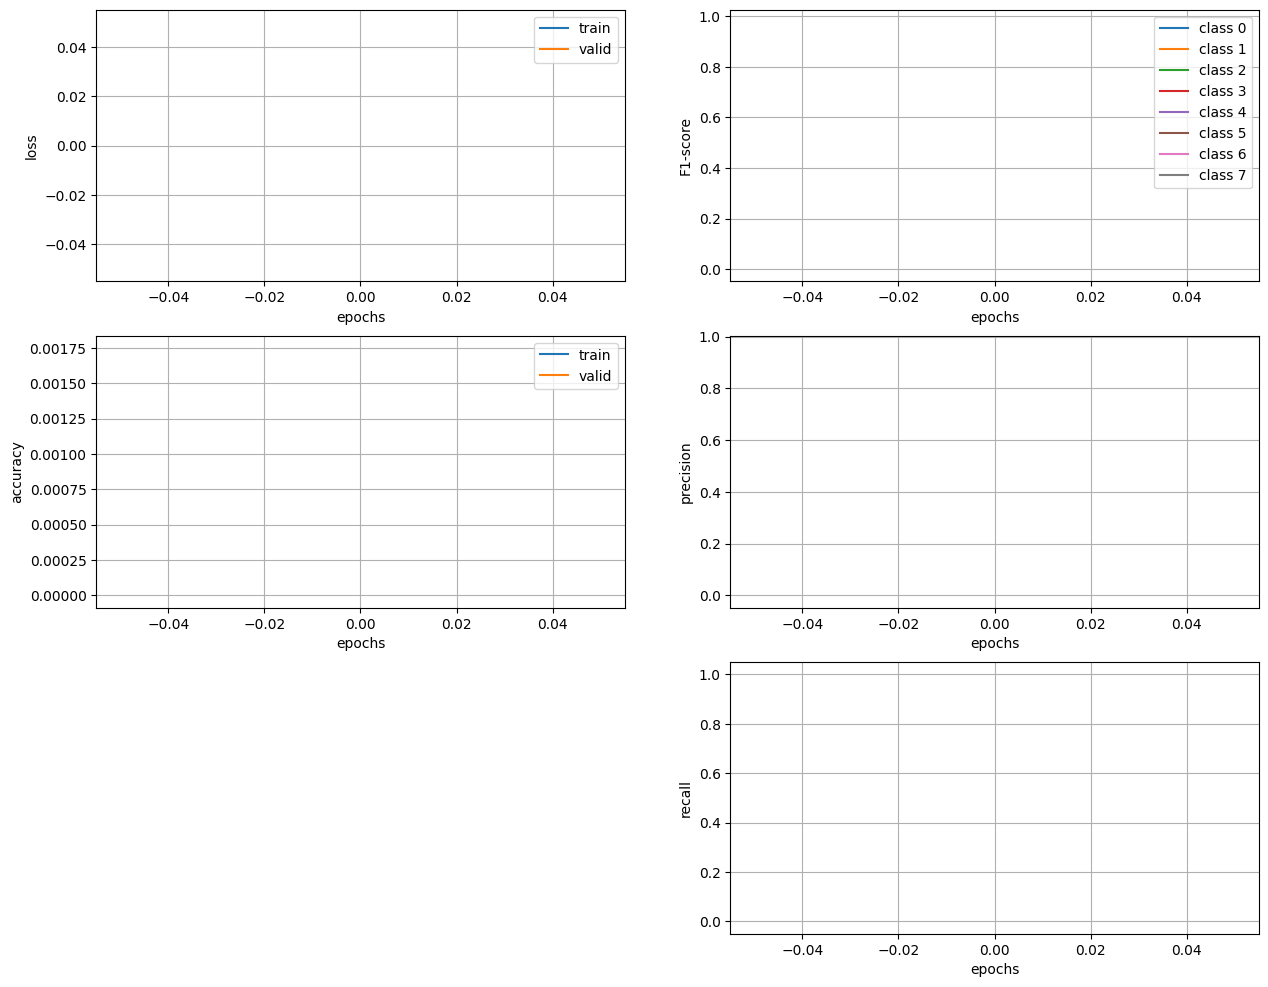

In [ ]:
# Initiate the training of the DeepFindET 3D U-Net model.
train_model(
    config,                 # Configuration file with various settings for the project.
    voxel_size,             # Voxel size used in the tomogram data.
    tomogram_algorithm,     # Reconstruction algorithm used for the tomograms (e.g., 'wbp').
    targets,                 # Target data for training the model.
    training_output_path,   # Path where the training outputs will be saved.
    model_name,             # Model architecture name ('res_unet').
    model_pre_weights,      # Pre-trained weights (None for training from scratch).
    n_class,                # Number of classes for segmentation (8 in this case).
    path_valid=None,        # Path to validation data (None means internal splitting may be used).
    dim_in=dim_in,          # Input dimension size in voxels.
    n_sub_epoch=10,         # Number of epochs to train on tomograms prior to swapping to a new set of tomograms.
    sample_size=1,          # Number of tomograms to extract per epoch.
    batch_size=10,          # Batch size used during training.
    epochs=70,              # Total number of training epochs.
    steps_per_epoch=150,    # Number of steps per epoch.
    n_valid=20,             # Number of validation samples.
    # model_filters=[48, 64, 128],  # Filters in the convolutional layers at each level of the U-Net.
    model_filters=[12, 16, 32],  # Filters in the convolutional layers at each level of the U-Net.
    model_dropout=0,        # Dropout rate (0 means no dropout applied).
    target_name="remotetargets",    # Name of the segmentation targets.
    target_user_id="deepfindET",  # User ID for the segmentation labels.
    target_session_id="0",    # Session ID associated with the labeling.
    valid_tomo_ids=None,    # List of tomogram IDs for validation.
    train_tomo_ids=None,     # List of tomogram IDs for training.
    class_weights=(('apo-ferritin', 1), ('beta-amylase', 0), ('beta-galactosidase', 2), ('ribosome', 1), ('thyroglobulin', 2), ('virus-like-particle', 1))
    # class_weights=(('apo-ferritin', 62400), ('beta-amylase', 4130), ('beta-galactosidase', 3080), ('ribosome', 1800), ('thyroglobulin', 10100), ('virus-like-particle', 8400))
)
# 10439:     # class_weights=(('membrane',1),('adp-mitochondrial',3000),('alkaline-phosphate',3000),('nucleosome',3000),('ribosome',750),('vault',500),('virus-like-capsid',750))


In [ ]:
# from deepfindET.utils import core
import h5py, os

# Set the path to the training history file
history_path = os.path.join(training_output_path, 'net_train_history.h5')

# Convert the HDF5 file containing the training history into a dictionary format
# This allows easy access to the training metrics like loss, accuracy, etc., stored during training
history = convert_hdf5_to_dictionary(history_path)

# Plot the training history to visualize the learning process
# The plot_history function will generate curves for metrics such as training and validation loss, accuracy, etc.
plot_history(history, save_figure=False)
plt.show()